In [1]:
import os
import mlflow
import optuna
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from langchain_openai import AzureChatOpenAI
from langgraph.graph import StateGraph
from typing import TypedDict
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# Global Configurations
MODEL_VERSION = "v1.0"
MODEL_ACCURACY = 0.0
EXPERIMENT_NAME = "Diabetes_MLOps_Agent"
DATA_PATH = "diabetes_prediction_dataset.csv"

In [3]:
# Load Dataset
df = pd.read_csv(DATA_PATH)
df = pd.get_dummies(df, columns=['smoking_history', 'gender'])
X = df.drop(columns=["diabetes"])
y = df["diabetes"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:
# Initialize MLflow
mlflow.set_experiment(EXPERIMENT_NAME)

<Experiment: artifact_location='file:///c:/Users/SV937CY/OneDrive%20-%20EY/Desktop/telstra_webscrapping/mlruns/466788862288058590', creation_time=1738904820851, experiment_id='466788862288058590', last_update_time=1738904820851, lifecycle_stage='active', name='Diabetes_MLOps_Agent', tags={}>

In [ ]:
# Initialize LLM for decision-making
llm = AzureChatOpenAI(
    deployment_name="gpt-4o",
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    api_version="2024-02-01"
)

In [6]:
# Hyperparameter Optimization Function
def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
    }
    model = xgb.XGBClassifier(**params, use_label_encoder=False, eval_metric="logloss")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return accuracy_score(y_test, preds)


In [7]:
# Train Initial Model
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
best_params = study.best_params
model = xgb.XGBClassifier(**best_params, use_label_encoder=False, eval_metric="logloss")
model.fit(X_train, y_train)
MODEL_ACCURACY = accuracy_score(y_test, model.predict(X_test))

[I 2025-03-25 16:27:32,638] A new study created in memory with name: no-name-78f1511d-6685-43aa-b600-4c1ec6859103
C:\Users\SV937CY\AppData\Local\Temp\ipykernel_25728\1848405486.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
c:\Users\SV937CY\bias_1\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:27:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-03-25 16:27:33,692] Trial 0 finished with value: 0.9725 and parameters: {'max_depth': 9, 'learning_rate': 0.03715983633451304, 'n_estimators': 234}. Best is trial 0 with value: 0.9725.
C:\Users\SV937CY\AppData\Loc

In [8]:
# Log Model to MLflow
with mlflow.start_run():
    mlflow.log_params(best_params)
    mlflow.log_metric("accuracy", MODEL_ACCURACY)
    mlflow.xgboost.log_model(model, "model")


2025/03/25 16:27:51 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet

c:\Users\SV937CY\bias_1\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:27:51] WARNING: C:\build

In [9]:
# MLOps Workflow Functions
def monitor_model(state):
    """Monitor model performance."""
    global MODEL_ACCURACY
    print(f"Monitoring Model: {MODEL_VERSION}, Accuracy: {MODEL_ACCURACY}")
    return {"status": "drift_detected"} if MODEL_ACCURACY < 0.75 else {"status": "model_healthy"}

def decide_retraining(state):
    """Decide if retraining is needed using an LLM."""
    response = llm.predict("The model accuracy dropped below the threshold. Should I retrain?")
    return {"status": "retrain"} if "yes" in response.lower() else {"status": "done"}

def retrain_model(state):
    """Retrain model with updated dataset & hyperparameters."""
    global MODEL_ACCURACY, MODEL_VERSION
    study.optimize(objective, n_trials=5)
    best_params = study.best_params
    new_model = xgb.XGBClassifier(**best_params, use_label_encoder=False, eval_metric="logloss")
    new_model.fit(X_train, y_train)
    MODEL_ACCURACY = accuracy_score(y_test, new_model.predict(X_test))
    MODEL_VERSION = "v" + str(int(MODEL_VERSION.split("v")[-1]) + 1)
    with mlflow.start_run():
        mlflow.log_params(best_params)
        mlflow.log_metric("new_accuracy", MODEL_ACCURACY)
        mlflow.xgboost.log_model(new_model, "model")
    return {"status": "deploy"}

def deploy_model(state):
    """Deploy the updated model."""
    print(f"Deploying Model {MODEL_VERSION} with Accuracy: {MODEL_ACCURACY}")
    return {"status": "done"}

def done(state):
    """End workflow."""
    print("MLOps Workflow Completed Successfully!")
    return state

In [10]:
# Define Workflow State Schema
class MLOpsState(TypedDict):
    status: str  # Workflow status (e.g., "monitoring", "retraining")

In [11]:
# Build Workflow with LangGraph
workflow = StateGraph(MLOpsState)
workflow.add_node("monitor", monitor_model)
workflow.add_node("decision", decide_retraining)
workflow.add_node("retrain", retrain_model)
workflow.add_node("deploy", deploy_model)
workflow.add_node("done", done)

workflow.set_entry_point("monitor")
workflow.add_conditional_edges("monitor", lambda state: "decision" if state["status"] == "drift_detected" else "done")
workflow.add_conditional_edges("decision", lambda state: "retrain" if state["status"] == "retrain" else "done")
workflow.add_edge("retrain", "deploy")
workflow.add_edge("deploy", "done")

In [12]:
# Compile and Run Workflow
agent = workflow.compile()
output = agent.invoke({"status": "monitoring"})
print("MLOps Workflow Output:", output)

Monitoring Model: v1.0, Accuracy: 0.9727
MLOps Workflow Completed Successfully!
MLOps Workflow Output: {'status': 'model_healthy'}


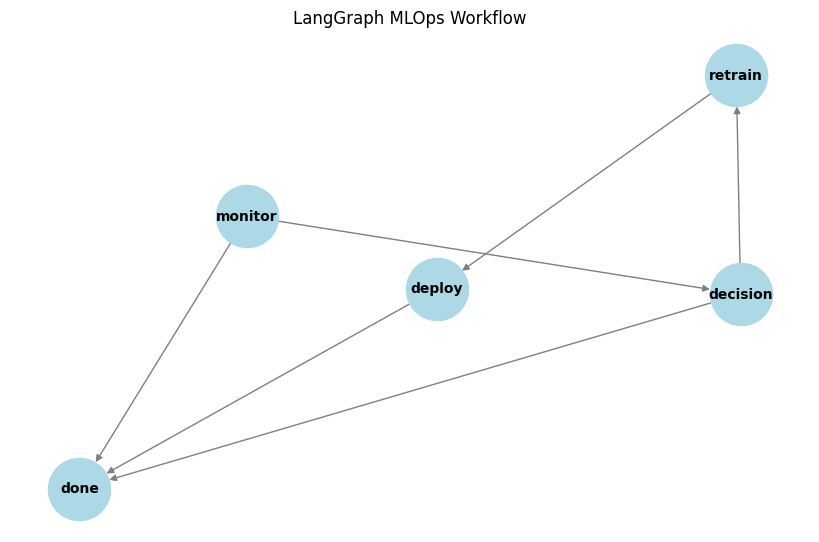

In [13]:
# Visualize Workflow
edges = [("monitor", "decision"), ("monitor", "done"), ("decision", "retrain"),
         ("decision", "done"), ("retrain", "deploy"), ("deploy", "done")]
G = nx.DiGraph()
G.add_edges_from(edges)
plt.figure(figsize=(8, 5))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=2000, font_size=10, font_weight="bold", arrows=True)
plt.title("LangGraph MLOps Workflow")
plt.show()
